## Problem 1: Visualize a static map

In [1]:
import glob
import numpy as np
import pysal as ps
import pandas as pd
import geopandas as gpd
import contextily as ctx
from geopandas.tools import geocode
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
# reading in the addresses of the six shopping centers and geocoding them
addresses = pd.read_csv('data/addresses.txt', sep=';')
addresses = geocode(addresses['address'], provider = 'nominatim', user_agent = 'autogis_student_er')

In [4]:
# reading in the TravelTime filepaths and MetropAccess shape file
filepaths = glob.glob('data/Travel*.txt')
grid = gpd.read_file('data/MetropAccess_YKR_grid_EurefFIN.shp')

# adding the car and pt data in the TravelTime files to the grid dataframe
for idx, fp in enumerate(filepaths):
    data = pd.read_csv(fp, sep=';')    
    data = data[['from_id', 'pt_r_t', 'car_r_t']]
    
    data.rename(columns={'pt_r_t': ('pt_r_t_' + str(idx))}, inplace=True)
    data.rename(columns={'car_r_t': ('car_r_t_' + str(idx))}, inplace=True)
    
    grid = grid.merge(data, left_on='YKR_ID', right_on='from_id')

# reporojecting the two dataframes
addresses = addresses.to_crs(epsg=3857)
grid = grid.to_crs(epsg=3857)    

# calculating the travel time by pt to the closest shopping center for each grid cell
cols_pt = ['pt_r_t_'+str(i) for i in range(0,7)]
grid['pt_min'] = grid[cols_pt].min(1)

# calculating the travel time by car to the closest shopping center for each grid cell
cols_car = ['car_r_t_'+str(i) for i in range(0,7)]
grid['car_min'] = grid[cols_car].min(1)

# creating a new dataframe that only has data for the car_min, pt_min, and geometry columns,
# ignoring all columns where car_min or pt_min is -1 (no data)
cols_subset = ['car_min', 'pt_min', 'geometry']
travel_times = grid[cols_subset].loc[np.where((grid['pt_min'] != -1) & (grid['car_min'] != -1))]

# creating a new column in the travel_times dataframe that shows the difference between travel
# times by car and pt to each gridcell's closest shopping center
travel_times['car_fast'] = travel_times['pt_min'] - travel_times['car_min']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


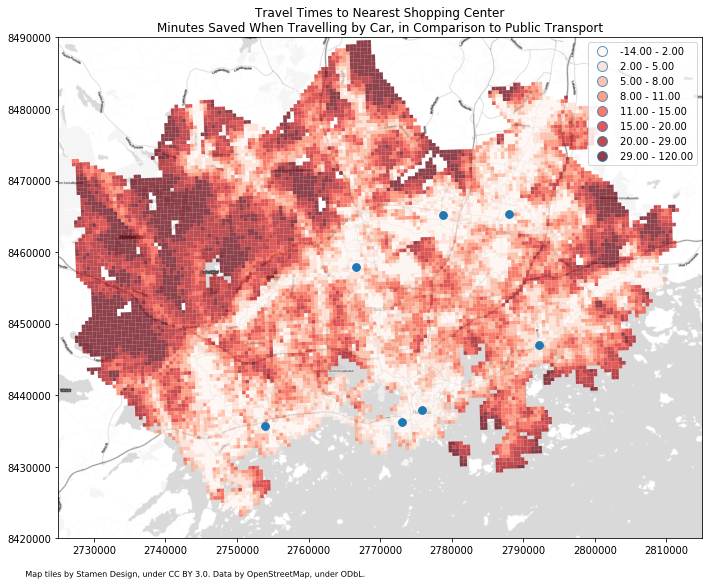

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10));

# plotting the minutes saved from travelling by car (in comparison to travelling by pt) to 
# the nearest shopping center 
travel_times.plot(column="car_fast", legend=True, cmap='Reds', linewidth=0, alpha=0.75, 
                       scheme='quantiles', k=8, ax=ax);

# adding a basemap
ctx.add_basemap(ax, url=ctx.tile_providers.ST_TONER_LITE);

# plotting the locations of the shopping centers
addresses['geometry'].plot(ax=ax, markersize=60);

# adding a title to the map
ax.set_title('Travel Times to Nearest Shopping Center\nMinutes Saved When Travelling by Car, in Comparison to Public Transport');

# setting the bounds for the map
ax.set_xbound(2725000, 2815000);
ax.set_ybound(8420000, 8490000);

fig.tight_layout()
fig.savefig('docs/Shopping_centers_accessibility_car_pt_comparisons.png')

It seems that as long as one lives close to Helsinki's main trasport axes, one's nearest shopping center is about as far away by car as by public transport. In a few cases public transport is even faster. However, in the not so well connected parts of Helsinki (especially the north-west) travelling by car is much faster than by public transport.